Synthetic data, one warehouse lost demand

In [1]:
%load_ext autoreload
%autoreload 2

import analysis.ray_results_interpreter as rri
from importlib import reload
import pandas as pd

from ray.tune import ExperimentAnalysis
import pandas as pd
import matplotlib.pyplot as plt

def merge_experiment_results(paths):
    dataframes = []
    for path in paths:
        analysis = ExperimentAnalysis(path)
        dataframes.append(analysis.dataframe())
    
    # Merge all dataframes
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    # Reorder columns
    columns_order = ['time_this_iter_s', 'time_total_s', 'iterations_since_restore']
    other_columns = [col for col in merged_df.columns if col not in columns_order]
    merged_df = merged_df[columns_order + other_columns]
    
    # Print the merged dataframe
    print(merged_df.to_string(index=False))
    
    # Calculate and print average time_total_s
    avg_time_total = merged_df['time_total_s'].mean()
    print(f"\nAverage time_total_s: {avg_time_total:.2f} seconds")
    # Calculate and print average time_total_s
    avg_time_total = merged_df['iterations_since_restore'].mean()
    print(f"\nAverage iterations_since_restore: {avg_time_total:.2f}")
    
    # Create scatter plot
    plt.figure(figsize=(5, 3))
    plt.scatter(merged_df.index, merged_df['iterations_since_restore'])
    plt.xlabel('Index')
    plt.ylabel('Iterations Since Restore')
    plt.title('Scatter Plot of Iterations Since Restore')
    plt.show()
    
    return merged_df

In [14]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3',
    10: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/10',
    20: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/20',
    50: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/50'
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/3,
    10: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/10',
    20: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/20',
    50: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/50'
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']

shared_conditions = {'warehouse_holding_cost': [0.7], 'warehouse_lead_time': [2], 'stores_correlation': [0.5]}
# shared_conditions = {'warehouse_holding_cost': [0.7], 'warehouse_lead_time': [6], 'stores_correlation': [0.5]}
# shared_conditions = {'warehouse_holding_cost': [1.0], 'warehouse_lead_time': [2], 'stores_correlation': [0.5]}
# shared_conditions = {'warehouse_holding_cost': [1.0], 'warehouse_lead_time': [6], 'stores_correlation': [0.5]}

condition_for_ctx = shared_conditions.copy()
condition_for_ctx['context'] = [0, 1, 64]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, condition_for_ctx, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, shared_conditions, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores', 'warehouse_holding_cost', 'warehouse_lead_time', 'stores_correlation'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.drop(columns=['warehouse_holding_cost', 'warehouse_lead_time', 'stores_correlation'], inplace=True)
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(shared_conditions)
print(df.to_string(index=False))

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [4]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/3',
    5: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/5',
    20: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/20',
    50: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/50',
    100: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/100'
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/3',
    5: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/5',
    20: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/20',
    50: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/50',
    100: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/100'
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']

results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 2, 4, 8, 16, 32, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0         0.0100    5.678947  5.667238   5.658443          9    3.297811         5.665088
           3     Symmatry_Aware           1.0         0.0100    5.494950  5.499710   5.489791          9    0.218976         5.487189
           3     Symmatry_Aware          32.0         0.0010    5.475683  5.493100   5.478564          9    0.014024         5.472106
           3     Symmatry_Aware          64.0         0.0001    5.476005  5.493236   5.477796          9    0.000000         5.474725
           3            Vanilla           NaN         0.0010    5.485427  5.499762   5.493346         39    0.283868         5.472646
           5     Symmatry_Aware           0.0         0.0001    5.292834  5.278422   5.309792          9    3.538914         5.292628
           5     Symmatry_Aware           1.0         0.0010  

In [5]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_large/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_large/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.001    5.677065  5.668593   5.659001          5    3.401764         5.670380
           3     Symmatry_Aware           1.0          0.010    5.484450  5.489308   5.473140          5    0.005710         5.484236
           3     Symmatry_Aware          64.0          0.001    5.480534  5.488657   5.472828          5    0.000000         5.477936
           3            Vanilla           NaN          0.001    5.481088  5.490378   5.477924         20    0.093108         5.473786


In [4]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_lead/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_lead/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.010    5.924473  5.930560   5.910807          9    1.531933         5.907070
           3     Symmatry_Aware           1.0          0.010    5.834254  5.850992   5.821624          9    0.000000         5.823745
           3     Symmatry_Aware          64.0          0.010    5.836678  5.855047   5.828812          9    0.123483         5.809814
           3            Vanilla           NaN          0.001    5.836746  5.855643   5.823750         25    0.036534         5.796001


In [3]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_large_lead/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_large_lead/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.010    5.939833  5.923935   5.904784          9    1.543459         5.921181
           3     Symmatry_Aware           1.0          0.010    5.845350  5.842640   5.815340          9    0.005311         5.841207
           3     Symmatry_Aware          64.0          0.010    5.837446  5.845638   5.815469          9    0.007529         5.836145
           3            Vanilla           NaN          0.001    5.847357  5.845670   5.815031         10    0.000000         5.836385


 time_this_iter_s  time_total_s  iterations_since_restore  dev_loss  train_loss  test_loss  timestamp checkpoint_dir_name  done  training_iteration    trial_id                date    pid      hostname        node_ip  time_since_restore  config/n_stores  config/learning_rate  config/context config/overriding_networks config/overriding_outputs  config/samples      logdir
       866.872476  54402.285268                        74  5.096229    5.098696   5.128291 1724960215                None False                  74 591b0_00006 2024-08-29_15-36-55 100169 researchgpu04 128.59.240.194        54402.285268                5                0.0010              32                  [context]                 [context]               1 591b0_00006
       422.219686 108697.749186                       400  5.110029    5.121015   5.145279 1725019678                None False                 400 591b0_00009 2024-08-30_08-07-58 124243 researchgpu04 128.59.240.194       108697.749186                5    

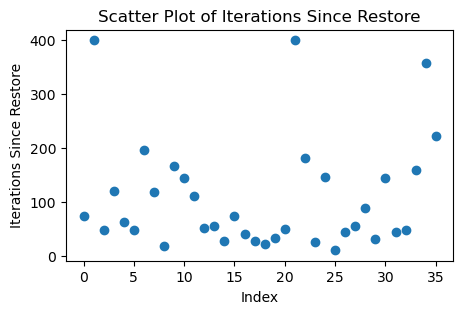

In [14]:
paths = [
    "/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/5/run_2024-08-29_00-29-57/experiment_state-2024-08-29_00-29-58.json",
]
merged_results = merge_experiment_results(paths)

In [4]:
weekly_forecast_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/weekly_forecast_NN',
}
data_driven_net_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/data_driven_net',
}
fixed_quantile_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/fixed_quantile',
}
quantile_nv_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/quantile_nv',
}
just_in_time_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/just_in_time',
}

#def custom_data_filler(out_row, reference_row):
#    out_row['path'] = reference_row['path']

results_interpretor = rri.RayResultsinterpreter()
df_weekly_forecast = results_interpretor.make_table(weekly_forecast_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_data_driven_net = results_interpretor.make_table(data_driven_net_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_fixed_quantile = results_interpretor.make_table(fixed_quantile_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_quantile_nv = results_interpretor.make_table(quantile_nv_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_weekly_forecast.insert(1, 'Architecture Class', "Weekly Forecast")
df_data_driven_net.insert(1, 'Architecture Class', "HDPO")
df_fixed_quantile.insert(1, 'Architecture Class', "Fixed Quantile")
df_quantile_nv.insert(1, 'Architecture Class', "Newsvendor")
df_just_in_time.insert(1, 'Architecture Class', "Oracle")

optimal_weeks = {
    4: 4.7298,
    6: 5.0385,
    9: 5.3489,
    13: 5.5832
}
df = pd.concat([df_weekly_forecast, df_data_driven_net, df_fixed_quantile, df_quantile_nv, df_just_in_time])

# Insert 'Optimal # of Weeks' next to 'Architecture Class' only for Weekly Forecast rows
architecture_class_index = df.columns.get_loc('Architecture Class')
df.insert(architecture_class_index + 1, 'Optimal # of Weeks', None)
df.loc[df['Architecture Class'] == 'Weekly Forecast', 'Optimal # of Weeks'] = df.loc[df['Architecture Class'] == 'Weekly Forecast', 'store_underage_cost'].map(optimal_weeks)

min_dev_loss = df.groupby(['store_underage_cost'])['Dev Loss'].transform('min')
df['Dev Gap %'] = -((df['Dev Loss'] - min_dev_loss) / min_dev_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Dev Gap %', df.pop('Dev Gap %'))
df.drop(columns=['# of stores', '# of runs'], inplace=True)
# Define the custom order for Architecture Class
architecture_order = ['Oracle', 'HDPO', 'Weekly Forecast', 'Fixed Quantile', 'Newsvendor']
# Create a categorical column with the custom order
df['Architecture Class'] = pd.Categorical(df['Architecture Class'], categories=architecture_order, ordered=True)
# Sort the dataframe
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
# Move store_underage_cost to the first column
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

print(df.to_string(index=False))
df.to_csv('results.csv', index=False)
print("Results saved to comparison_results.csv")

 store_underage_cost Architecture Class Optimal # of Weeks  Train Loss    Dev Loss  Dev Gap %
                   4             Oracle               None -213.665006 -198.463167   0.000000
                   4               HDPO               None -161.395985 -150.136966  24.350211
                   4    Weekly Forecast             4.7298 -144.881375 -134.072153  32.444819
                   4     Fixed Quantile               None -150.145288 -139.585469  29.666814
                   4         Newsvendor               None -134.674537 -120.307394  39.380493
                   6             Oracle               None -320.510398 -297.704852   0.000000
                   6               HDPO               None -255.922236 -236.749878  20.474968
                   6    Weekly Forecast             5.0385 -238.705123 -220.377574  25.974477
                   6     Fixed Quantile               None -243.081326 -225.572379  24.229526
                   6         Newsvendor               None -

In [41]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
def custom_data_filler(out_row, reference_row):
    out_row['best_test_loss'] = reference_row['best_test_loss']
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [1, 2, 4, 8, 16, 32, 64], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'learning_rate': [0.1, 0.01, 0.001, 0.0001]}, custom_data_filler, sort_by='best_test_loss')
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'for_all_networks': [1, 2, 4, 8, 16, 32, 64], 'samples': [1, 2, 3, 4, 5], 'learning_rate': [0.1, 0.01, 0.001, 0.0001]}, custom_data_filler, sort_by='best_test_loss')
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
# df = pd.concat([df_ctx, df_gnn, df_gnn_mp, df_custom_stemb, df_vanilla])
df = pd.concat([df_ctx])

# Move 'master size' column next to 'context size'
if 'master' in df.columns:
    context_size_index = df.columns.get_loc('context size')
    master_size = df.pop('master')
    df.insert(context_size_index + 1, 'master', master_size)

min_test_loss = df.groupby(['# of stores'])['best_test_loss'].transform('min')
df['Test Gap %'] = ((df['best_test_loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
# df.sort_values(by=['# of stores', 'context size', 'master'], inplace=True)
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  context size  samples  learning_rate  Learning Rate  Train Loss   Dev Loss   Test Loss  # of runs   Test Gap %  best_test_loss
          50     Symmatry_Aware             8        1         0.0001         0.0001    5.650241   7.421216   10.879798          1    46.751336        8.233992
          50     Symmatry_Aware             8        1         0.0010         0.0010   49.578414  44.554602   41.513131          1   639.152508       41.472713
          50     Symmatry_Aware             8        1         0.0100         0.0100  288.772125  37.387215   34.642025          1   517.411742       34.642025
          50     Symmatry_Aware             8        2         0.0001         0.0001   18.192926  20.490166  119.765963          1   418.095789       29.069559
          50     Symmatry_Aware             8        2         0.0010         0.0010   11.473066  11.937699  148.274425          1   223.611793       18.157361
          50     Symmatry_Aware         

In [26]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN/50',
}
gnn_wistemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_WISTEMB/50',
}
gnn_pna_wistemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_PNA_WISTEMB/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_PNA/50',
}
gnn_mp_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_message_passing/50',
}
gnn_noctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_NoCtx/50',
}
gnn_noctx_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_NoCtx_PNA/50',
}
gnn_separation_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_Separation/50',
}
gnn_separation_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_Separation_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/vanilla/50',
}
gnn_no_aggregation_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_No_Aggregation/50',
}

def custom_data_filler(out_row, reference_row):
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [4, 8, 16, 32, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_wistemb = results_interpretor.make_table(gnn_wistemb_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_wistemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna_wistemb = results_interpretor.make_table(gnn_pna_wistemb_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_pna_wistemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_separation = results_interpretor.make_table(gnn_separation_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_separation.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_separation_pna = results_interpretor.make_table(gnn_separation_pna_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_separation_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_mp = results_interpretor.make_table(gnn_mp_paths, {'context': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_mp.rename(columns={'context': 'context size'}, inplace=True)

df_gnn_noctx = results_interpretor.make_table(gnn_noctx_paths, {}, custom_data_filler)

df_gnn_noctx_pna = results_interpretor.make_table(gnn_noctx_pna_paths, {}, custom_data_filler)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'master': [128, 512]}, custom_data_filler)

df_gnn_no_aggregation = results_interpretor.make_table(gnn_no_aggregation_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_no_aggregation.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_wistemb.insert(1, 'Architecture Class', "GNN_WISTEMB")
df_gnn_mp.insert(1, 'Architecture Class', "GNN_MP")
df_gnn_pna_wistemb.insert(1, 'Architecture Class', "GNN_PNA_WISTEMB")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_separation.insert(1, 'Architecture Class', "GNN_Separation")
df_gnn_separation_pna.insert(1, 'Architecture Class', "GNN_Separation_PNA")
df_gnn_noctx.insert(1, 'Architecture Class', "GNN_NoCtx")
df_gnn_noctx_pna.insert(1, 'Architecture Class', "GNN_NoCtx_PNA")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn_no_aggregation.insert(1, 'Architecture Class', "GNN_No_Aggregation")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_gnn_noctx, df_gnn_noctx_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_no_aggregation])

# Move 'master size' column next to 'context size'
if 'master' in df.columns:
    context_size_index = df.columns.get_loc('context size')
    master_size = df.pop('master')
    df.insert(context_size_index + 1, 'master', master_size)

#min_test_loss = df.groupby(['# of stores', 'context size'])['Test Loss'].transform('min')
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %(all)'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %(all)', df.pop('Test Gap %(all)'))
min_test_loss = df.groupby(['# of stores', 'context size'])['Test Loss'].transform('min')
df['Test Gap %(context)'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %(context)', df.pop('Test Gap %(context)'))
# df.sort_values(by=['# of stores', 'context size', 'master'], inplace=True)
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %(all)  Test Gap %(context)  # of runs
          50     Symmatry_Aware             4         0.0001    5.267518  5.246959   5.264585         0.751766             0.369205         18
          50                GNN             4         0.0010    5.273201  5.248708   5.270007         0.855535             0.472581         17
          50 GNN_No_Aggregation             4         0.0010    5.252612  5.228131   5.245219         0.381153             0.000000          9
          50     Symmatry_Aware             8         0.0001    5.255547  5.235310   5.252848         0.527160             0.264266         18
          50                GNN             8         0.0001    5.241436  5.221542   5.239004         0.262201             0.000000         18
          50 GNN_No_Aggregation             8         0.0001    6.770121  6.744790   6.909938        32.239961            31.894133          9

In [27]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
gnn_larger_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_larger_stemb/50',
}
gnn_relu_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_ReLU_stemb/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_PNA/50',
}
gnn_noctx_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_NoCtx_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/vanilla/50',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
sort_by = 'test_loss'
training_n_samples = [1]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_larger_stemb = results_interpretor.make_table(gnn_larger_stemb_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_larger_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_relu_stemb = results_interpretor.make_table(gnn_relu_stemb_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_relu_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_attention['training_n_samples'] = training_n_samples[0]
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_noctx_pna = results_interpretor.make_table(gnn_noctx_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_noctx_pna.insert(1, 'Architecture Class', "GNN_NoCtx_PNA")
df_gnn_relu_stemb.insert(1, 'Architecture Class', "GNN_ReLU_STEMB")
df_gnn_larger_stemb.insert(1, 'Architecture Class', "GNN_Larger_STEMB")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_gnn_noctx, df_gnn_noctx_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_attention, df_gnn_pna, df_gnn_noctx_pna, df_gnn_relu_stemb, df_gnn_larger_stemb, df_vanilla])
df.drop(columns=['Dev Loss', 'Learning Rate', 'samples'], inplace=True)

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    'Test Loss': 'mean',
    'best_train_loss': 'mean',
    '# of runs': 'sum'
}).reset_index()
df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', 'Test Loss', '# of runs']]
df = df_avg

min_test_loss = 5.218509
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
df.rename(columns={'Train Loss': 'Train Loss(at best test loss)'}, inplace=True)
#df.drop(columns=['# of runs'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss(at best test loss)  Test Loss  Test Gap %  # of runs
          50                GNN                   1                       5.538947   6.432312   23.259580        360
          50      GNN_Attention                   1                       5.448897   5.751466   10.212819        648
          50   GNN_Larger_STEMB                   1                       4.947377   6.359499   21.864285        324
          50      GNN_NoCtx_PNA                   1                       6.747120   7.348398   40.814133        108
          50            GNN_PNA                   1                       5.321012   6.353386   21.747159        360
          50     GNN_ReLU_STEMB                   1                       4.958621   6.475248   24.082342        324
          50     Symmatry_Aware                   1                       4.379046   5.959442   14.198182        360
          50            Vanilla                   1             

In [5]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
gnn_larger_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_larger_stemb/50',
}
gnn_relu_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_ReLU_stemb/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_PNA/50',
}
gnn_noctx_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_NoCtx_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/vanilla/50',
}

def custom_data_filler(out_row, reference_row):
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
sort_by = 'train_loss'
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_larger_stemb = results_interpretor.make_table(gnn_larger_stemb_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_larger_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_relu_stemb = results_interpretor.make_table(gnn_relu_stemb_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_relu_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_attention['training_n_samples'] = 1
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_noctx_pna = results_interpretor.make_table(gnn_noctx_pna_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_noctx_pna.insert(1, 'Architecture Class', "GNN_NoCtx_PNA")
df_gnn_relu_stemb.insert(1, 'Architecture Class', "GNN_ReLU_STEMB")
df_gnn_larger_stemb.insert(1, 'Architecture Class', "GNN_Larger_STEMB")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_gnn_noctx, df_gnn_noctx_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_pna, df_gnn_noctx_pna, df_gnn_attention, df_gnn_relu_stemb, df_gnn_larger_stemb, df_vanilla])
df.drop(columns=['Test Loss', 'Dev Loss', 'Learning Rate', 'samples'], inplace=True)

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    '# of runs': 'sum'
}).reset_index()
df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', '# of runs']]
df = df_avg
#df.drop(columns=['# of runs'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss  # of runs
          50                GNN                   1    4.560037        360
          50      GNN_Attention                   1    4.619906        324
          50   GNN_Larger_STEMB                   1    4.625154        324
          50      GNN_NoCtx_PNA                   1    4.351136        108
          50            GNN_PNA                   1    4.463108        360
          50     GNN_ReLU_STEMB                   1    4.644932        324
          50     Symmatry_Aware                   1    3.664529        360
          50            Vanilla                   1    2.990698        216


In [8]:
sort_by = 'test_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx/50',
}
ctx_decentralized_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx_decentralized/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/vanilla/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN_PNA/50',
}
gnn_noctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN_NoCtx/50',
}
gnn_mp_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN_message_passing/50',
}
gnn_wistemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN_WISTEMB/50',
}
gnn_large_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN_large/50',
}
gnn_no_aggregation_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN_No_Aggregation/50',
}
gnn_no_aggregation_randomize_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN_No_Aggregation_Randomize/50',
}

training_n_samples = [1, 2, 4, 8, 16, 256, 8192]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_ctx_decentralized = results_interpretor.make_table(ctx_decentralized_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_ctx_decentralized.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_noctx = results_interpretor.make_table(gnn_noctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn_mp = results_interpretor.make_table(gnn_mp_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_wistemb = results_interpretor.make_table(gnn_wistemb_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_wistemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_large = results_interpretor.make_table(gnn_large_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_large.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_no_aggregation = results_interpretor.make_table(gnn_no_aggregation_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_no_aggregation.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_no_aggregation_randomize = results_interpretor.make_table(gnn_no_aggregation_randomize_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_no_aggregation_randomize.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_ctx_decentralized.insert(1, 'Architecture Class', "Symmatry_Aware_Decentralized")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_noctx.insert(1, 'Architecture Class', "GNN_NoCtx")
df_gnn_mp.insert(1, 'Architecture Class', "GNN_MP")
df_gnn_wistemb.insert(1, 'Architecture Class', "GNN_WISTEMB")
df_gnn_large.insert(1, 'Architecture Class', "GNN_Large")
df_gnn_no_aggregation.insert(1, 'Architecture Class', "GNN_No_Aggregation")
df_gnn_no_aggregation_randomize.insert(1, 'Architecture Class', "GNN_No_Aggregation_Randomize")

df = pd.concat([df_ctx, df_ctx_decentralized, df_gnn, df_gnn_pna, df_gnn_noctx, df_gnn_attention, df_gnn_mp, df_gnn_wistemb
                , df_gnn_large, df_gnn_no_aggregation, df_gnn_no_aggregation_randomize, df_vanilla])

df.drop(columns=['Learning Rate', 'samples'], inplace=True)

min_test_loss = 5.36
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    'Dev Loss': 'mean',
    'Test Loss': 'mean',
    'Test Gap %': ['mean', 'std'],
    '# of runs': 'sum'
}).reset_index()

# Flatten column names
df_avg.columns = ['_'.join(col).strip() for col in df_avg.columns.values]

# Rename columns for clarity
df_avg.rename(columns={
    '# of stores_': '# of stores',
    'Architecture Class_': 'Architecture Class',
    'training_n_samples_': 'training_n_samples',
    'Train Loss_mean': 'Train Loss',
    'Dev Loss_mean': 'Dev Loss',
    'Test Loss_mean': 'Test Loss',
    'Test Gap %_mean': 'Test Gap %',
    'Test Gap %_std': 'Test Gap % Std',
    '# of runs_sum': '# of runs'
}, inplace=True)

df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', 'Dev Loss', 'Test Loss', 'Test Gap %', 'Test Gap % Std', '# of runs']]
df = df_avg

df.sort_values(by=['# of stores', 'training_n_samples'], inplace=True)
print(df.to_string(index=False))

 # of stores           Architecture Class  training_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %  Test Gap % Std  # of runs
          50                          GNN                   1    4.641618  6.198390   6.007635   12.082738        5.204166        108
          50                GNN_Attention                   1    4.700235  5.945181   6.002791   11.992376        5.602812        108
          50                    GNN_Large                   1    4.918193  6.035665   6.060260   13.064559        5.861112        108
          50                       GNN_MP                   1    4.730346  5.957016   5.995472   11.855823        8.944233        108
          50                    GNN_NoCtx                   1    7.773015  9.218536   9.794621   82.735472       39.449277        108
          50           GNN_No_Aggregation                   1    4.588804  5.893529   5.910657   10.273451        3.916523        108
          50 GNN_No_Aggregation_Randomize                   1 

In [21]:
sort_by = 'test_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx/3',
    5: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx/5',
    10: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx/10',
    20: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx/20',
    30: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx/30',
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx/50',
    #200: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/ctx/200',
}
gnn_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN/3',
    5: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN/5',
    10: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN/10',
    20: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN/20',
    30: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN/30',
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN/50',
    #200: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/GNN/200',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/vanilla/3',
    5: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/vanilla/5',
    10: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/vanilla/10',
    20: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/vanilla/20',
    30: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/vanilla/30',
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency/vanilla/50',
}

training_n_samples = [1, 2, 4, 8, 16, 256, 8192]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

df = pd.concat([df_ctx, df_gnn, df_vanilla])
# df = pd.concat([df_ctx, df_gnn])

df.drop(columns=['Learning Rate', 'samples'], inplace=True)

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = (df['Test Loss']/ min_test_loss) * 100

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    'Dev Loss': 'mean',
    'Test Loss': 'mean',
    'Test Gap %': ['mean', 'std'],
    '# of runs': 'sum'
}).reset_index()

# Flatten column names
df_avg.columns = ['_'.join(col).strip() for col in df_avg.columns.values]

# Rename columns for clarity
df_avg.rename(columns={
    '# of stores_': '# of stores',
    'Architecture Class_': 'Architecture Class',
    'training_n_samples_': 'training_n_samples',
    'Train Loss_mean': 'Train Loss',
    'Dev Loss_mean': 'Dev Loss',
    'Test Loss_mean': 'Test Loss',
    'Test Gap %_mean': 'Test Gap %',
    'Test Gap %_std': 'Test Gap % Std',
    '# of runs_sum': '# of runs'
}, inplace=True)

df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', 'Dev Loss', 'Test Loss', 'Test Gap %', 'Test Gap % Std', '# of runs']]
df = df_avg

df.sort_values(by=['# of stores', 'training_n_samples'], inplace=True)
print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %  Test Gap % Std  # of runs
           3                GNN                   1    4.902669  6.346490   6.654475  118.647254       11.727448        108
           3     Symmatry_Aware                   1    5.136106  6.414436   6.578398  117.290826        9.669637        108
           3                GNN                   2    5.545392  6.072444   6.099410  108.750621        3.270067        108
           3     Symmatry_Aware                   2    5.579699  6.204746   6.251371  111.460027        6.242351        108
           3                GNN                   4    5.772263  5.978983   5.988981  106.781695        2.123602        108
           3     Symmatry_Aware                   4    5.678632  6.003942   6.009671  107.150603        1.814560        108
           3                GNN                   8    5.540118  5.848575   5.853717  104.369992        1.460754        108
        

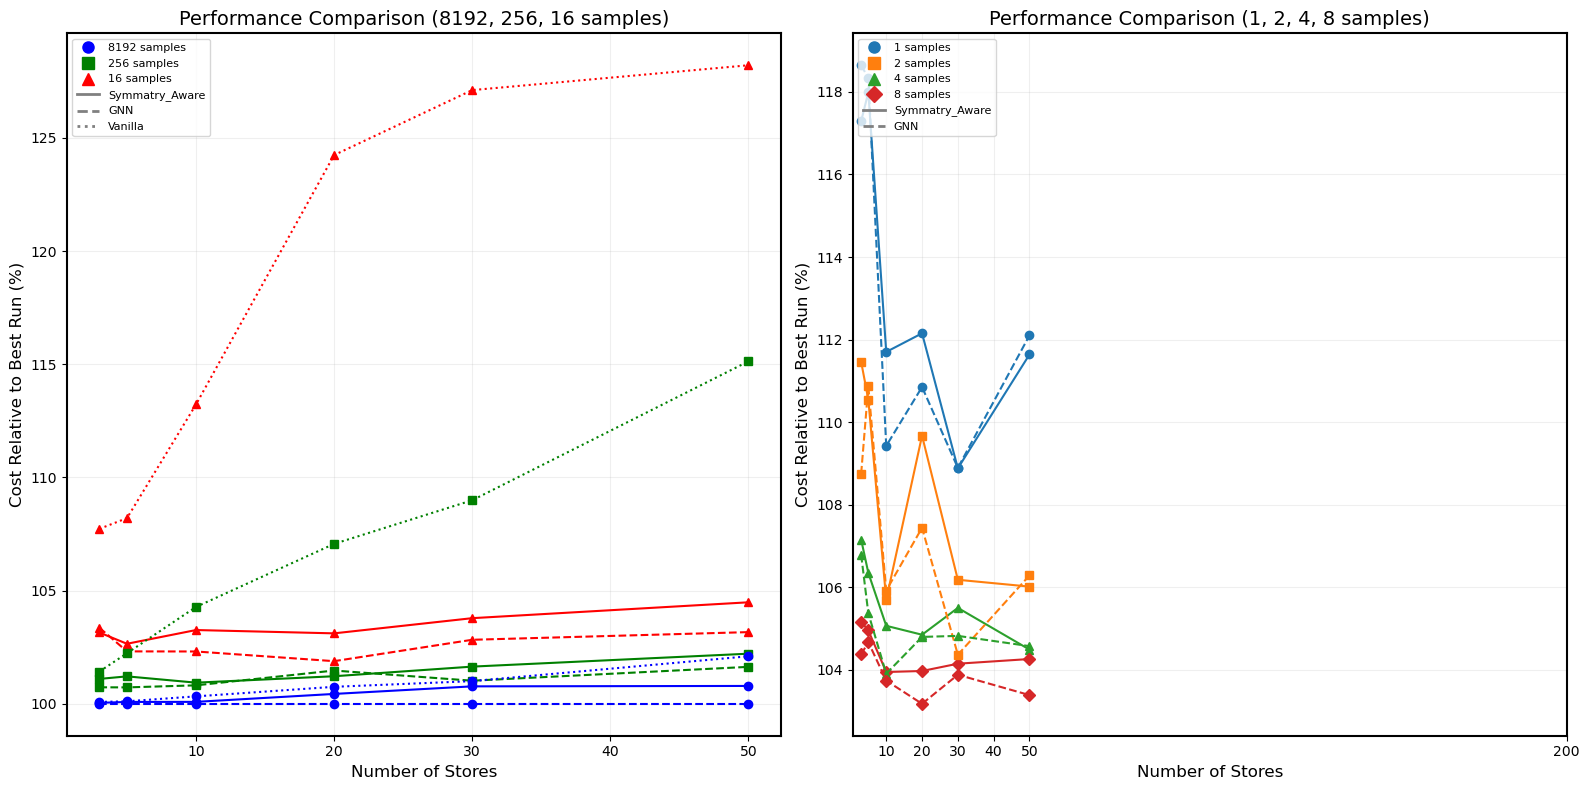

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot style
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Define colors for different training_n_samples
colors = {8192: 'blue', 256: 'green', 16: 'red'}

# Define line styles for different architecture classes
line_styles = {'Symmatry_Aware': '-', 'GNN': '--', 'Vanilla': ':'}

# Define markers for different training_n_samples
markers = {8192: 'o', 256: 's', 16: '^'}

# Plot lines for each architecture and training_n_samples combination in the first subplot
for arch in df['Architecture Class'].unique():
    for n_samples in [8192, 256, 16]:
        data = df[(df['Architecture Class'] == arch) & (df['training_n_samples'] == n_samples)]
        ax1.plot(data['# of stores'], data['Test Gap %'], 
                 color=colors[n_samples],
                 linestyle=line_styles[arch],
                 marker=markers[n_samples],
                 label=f'{arch}, {n_samples} samples')

# Customize the first subplot
ax1.set_xlabel('Number of Stores', fontsize=12)
ax1.set_ylabel('Cost Relative to Best Run (%)', fontsize=12)
ax1.set_title('Performance Comparison (8192, 256, 16 samples)', fontsize=14)
ax1.set_xticks([10, 20, 30, 40, 50])
ax1.set_xticklabels(['10', '20', '30', '40', '50'])
ax1.grid(True, which="both", ls="-", alpha=0.2)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)

# Define new colors, line styles, and markers for the second subplot
colors_2 = {1: '#1f77b4', 2: '#ff7f0e', 4: '#2ca02c', 8: '#d62728'}
markers_2 = {1: 'o', 2: 's', 4: '^', 8: 'D'}

# Plot lines for each architecture and training_n_samples combination in the second subplot
for arch in ['Symmatry_Aware', 'GNN']:  # Removed 'Vanilla'
    for n_samples in [1, 2, 4, 8]:
        data = df[(df['Architecture Class'] == arch) & (df['training_n_samples'] == n_samples)]
        mean = data['Test Gap %']
        std = data['Test Gap % Std']
        x = data['# of stores']
        
        # Plot the mean line
        ax2.plot(x, mean, 
                 color=colors_2[n_samples],
                 linestyle=line_styles[arch],
                 marker=markers_2[n_samples],
                 label=f'{arch}, {n_samples} samples')
        
        # # Plot the 95% confidence interval
        # ax2.fill_between(x, mean - 1.96*std/np.sqrt(12), mean + 1.96*std/np.sqrt(12), 
        #                  color=colors_2[n_samples], alpha=0.2)

# Customize the second subplot
ax2.set_xlabel('Number of Stores', fontsize=12)
ax2.set_ylabel('Cost Relative to Best Run (%)', fontsize=12)
ax2.set_title('Performance Comparison (1, 2, 4, 8 samples)', fontsize=14)
ax2.set_xticks([10, 20, 30, 40, 50, 200])
ax2.set_xticklabels(['10', '20', '30', '40', '50', '200'])
ax2.grid(True, which="both", ls="-", alpha=0.2)
ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

# Create custom legend for first subplot
legend_elements_1 = []

# Add marker legend for first subplot (8192, 256, 16 samples)
for n_samples, marker in markers.items():
    legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color=colors[n_samples], linestyle='None', markersize=8, label=f'{n_samples} samples'))

# Add line style legend for first subplot (all architecture types)
for arch, style in line_styles.items():
    legend_elements_1.append(plt.Line2D([0], [0], color='gray', linestyle=style, lw=2, label=arch))

# Add the legend to the first subplot
ax1.legend(handles=legend_elements_1, loc='upper left', fontsize=8)

# Create custom legend for second subplot
legend_elements_2 = []

# Add marker legend for second subplot (1, 2, 4, 8 samples)
for n_samples, marker in markers_2.items():
    legend_elements_2.append(plt.Line2D([0], [0], marker=marker, color=colors_2[n_samples], linestyle='None', markersize=8, label=f'{n_samples} samples'))

# Add line style legend for second subplot (only Symmatry_Aware and GNN)
for arch, style in {k: v for k, v in line_styles.items() if k != 'Vanilla'}.items():
    legend_elements_2.append(plt.Line2D([0], [0], color='gray', linestyle=style, lw=2, label=arch))

# Add the legend to the second subplot
ax2.legend(handles=legend_elements_2, loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

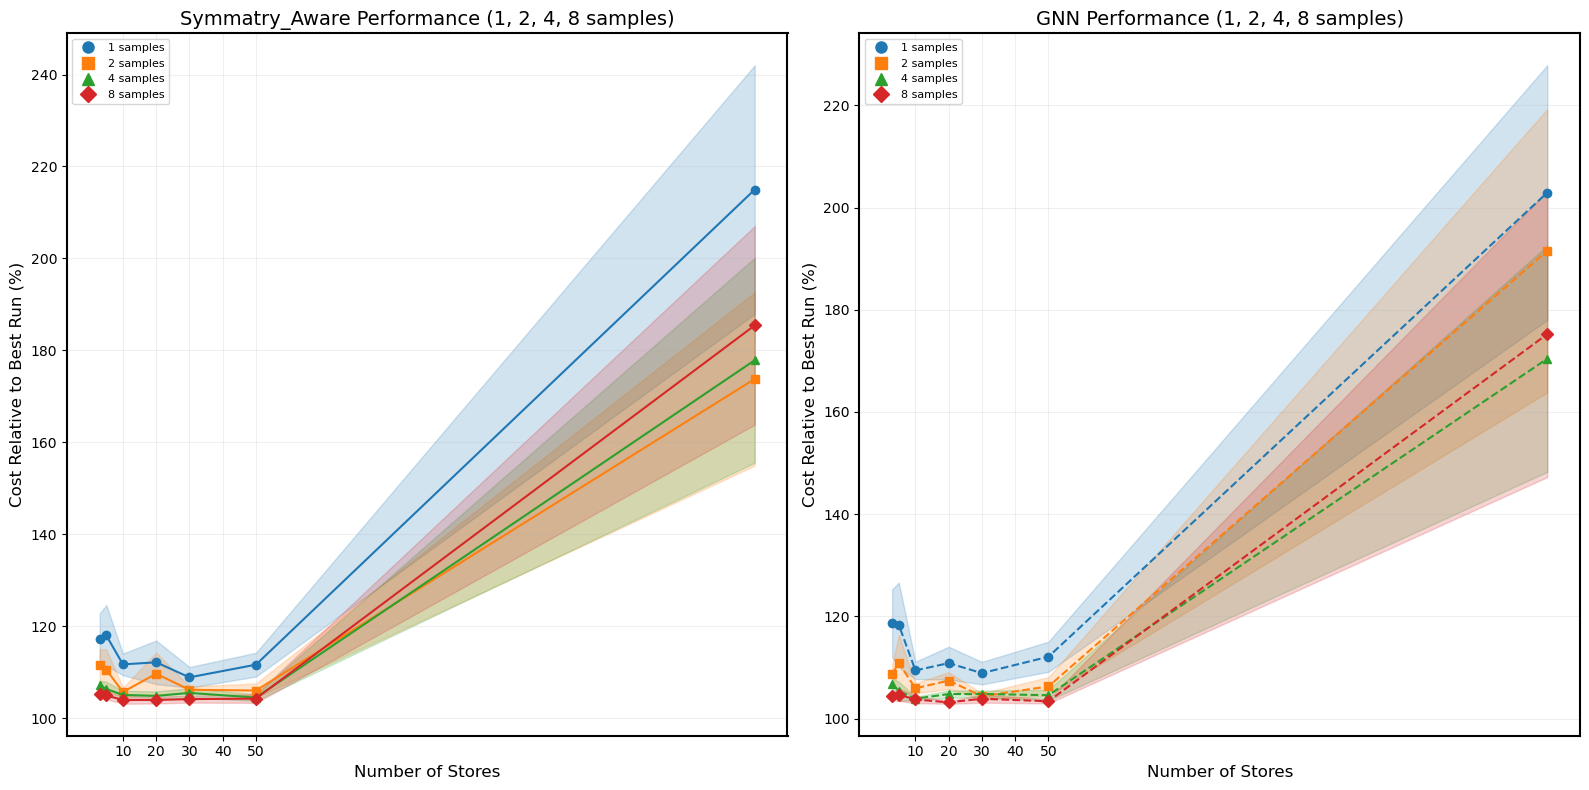

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot style
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Define colors for different training_n_samples
colors_2 = {1: '#1f77b4', 2: '#ff7f0e', 4: '#2ca02c', 8: '#d62728'}

# Define line styles for different architecture classes
line_styles = {'Symmatry_Aware': '-', 'GNN': '--'}

# Define markers for different training_n_samples
markers_2 = {1: 'o', 2: 's', 4: '^', 8: 'D'}

# Plot lines for Symmatry_Aware in the first subplot
for n_samples in [1, 2, 4, 8]:
    data = df[(df['Architecture Class'] == 'Symmatry_Aware') & (df['training_n_samples'] == n_samples)]
    mean = data['Test Gap %']
    std = data['Test Gap % Std']
    x = data['# of stores']
    
    # Plot the mean line
    ax1.plot(x, mean, 
             color=colors_2[n_samples],
             linestyle=line_styles['Symmatry_Aware'],
             marker=markers_2[n_samples],
             label=f'{n_samples} samples')
    
    # Plot the 95% confidence interval
    ax1.fill_between(x, mean - 1.96*std/np.sqrt(12), mean + 1.96*std/np.sqrt(12), 
                     color=colors_2[n_samples], alpha=0.2)

# Plot lines for GNN in the second subplot
for n_samples in [1, 2, 4, 8]:
    data = df[(df['Architecture Class'] == 'GNN') & (df['training_n_samples'] == n_samples)]
    mean = data['Test Gap %']
    std = data['Test Gap % Std']
    x = data['# of stores']
    
    # Plot the mean line
    ax2.plot(x, mean, 
             color=colors_2[n_samples],
             linestyle=line_styles['GNN'],
             marker=markers_2[n_samples],
             label=f'{n_samples} samples')
    
    # Plot the 95% confidence interval
    ax2.fill_between(x, mean - 1.96*std/np.sqrt(12), mean + 1.96*std/np.sqrt(12), 
                     color=colors_2[n_samples], alpha=0.2)

# Customize the first subplot (Symmatry_Aware)
ax1.set_xlabel('Number of Stores', fontsize=12)
ax1.set_ylabel('Cost Relative to Best Run (%)', fontsize=12)
ax1.set_title('Symmatry_Aware Performance (1, 2, 4, 8 samples)', fontsize=14)
ax1.set_xticks([10, 20, 30, 40, 50])
ax1.set_xticklabels(['10', '20', '30', '40', '50'])
ax1.grid(True, which="both", ls="-", alpha=0.2)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)

# Customize the second subplot (GNN)
ax2.set_xlabel('Number of Stores', fontsize=12)
ax2.set_ylabel('Cost Relative to Best Run (%)', fontsize=12)
ax2.set_title('GNN Performance (1, 2, 4, 8 samples)', fontsize=14)
ax2.set_xticks([10, 20, 30, 40, 50])
ax2.set_xticklabels(['10', '20', '30', '40', '50'])
ax2.grid(True, which="both", ls="-", alpha=0.2)
ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

# Create custom legend
legend_elements = []

# Add marker legend for samples
for n_samples, marker in markers_2.items():
    legend_elements.append(plt.Line2D([0], [0], marker=marker, color=colors_2[n_samples], linestyle='None', markersize=8, label=f'{n_samples} samples'))

# Add the legend to both subplots
ax1.legend(handles=legend_elements, loc='upper left', fontsize=8)
ax2.legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [107]:
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

symmetry_aware_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/symmetry_aware',
}
vanilla_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/vanilla',
}
gnn_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/GNN',
}
gnn_pna_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/GNN_PNA',
}
gnn_MP_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/GNN_message_passing',
}
symmetry_aware_decentralized_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/symmetry_aware_decentralized',
}


store_underage_cost = [4, 6, 9, 13]
results_interpretor = rri.RayResultsinterpreter()
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn = results_interpretor.make_table(gnn_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn_MP = results_interpretor.make_table(gnn_MP_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware_decentralized = results_interpretor.make_table(symmetry_aware_decentralized_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_MP.insert(1, 'Architecture Class', "GNN_MP")
df_symmetry_aware_decentralized.insert(1, 'Architecture Class', "Symmatry_Aware_Decentralized")
# df = pd.concat([df_symmetry_aware, df_vanilla, df_gnn, df_gnn_pna, df_gnn_MP])
df_416_fixed = pd.concat([df_symmetry_aware, df_vanilla, df_gnn, df_symmetry_aware_decentralized])

min_dev_loss = df_416_fixed.groupby('store_underage_cost')['Dev Loss'].min()
df_416_fixed['Dev Gap %'] = df_416_fixed.apply(lambda row: ((row['Dev Loss'] - min_dev_loss[row['store_underage_cost']]) / min_dev_loss[row['store_underage_cost']]) * 100, axis=1)
df_416_fixed['Dev Gap %'] = df_416_fixed['Dev Gap %'].round(2) * -1 + 100
columns = df_416_fixed.columns.tolist()
runs_column = columns.pop(columns.index(('# of runs')))
df_416_fixed = df_416_fixed[columns + [runs_column]]
df_416_fixed = df_416_fixed.drop('# of stores', axis=1)
df_416_fixed['n_samples'] = 416

df_416_fixed.sort_values(by=['store_underage_cost'], inplace=True)
print('store primitives fixed over samples. n_samples = 416')
print(df_416_fixed.to_string(index=False))

store primitives fixed over samples. n_samples = 416
          Architecture Class  store_underage_cost  Learning Rate  Train Loss    Dev Loss  Dev Gap %  # of runs  n_samples
              Symmatry_Aware                    4         0.0010 -177.818878 -157.309743     100.76         30        416
                     Vanilla                    4         0.0001 -176.650336 -158.506840     100.00         60        416
                         GNN                    4         0.0001 -161.654051 -143.496712     109.47         30        416
Symmatry_Aware_Decentralized                    4         0.0010 -159.134165 -137.239077     113.42         18        416
              Symmatry_Aware                    6         0.0010 -280.378497 -252.941088     100.00         30        416
                     Vanilla                    6         0.0010 -279.588696 -251.606299     100.53         60        416
                         GNN                    6         0.0001 -258.956266 -230.632742     

In [29]:
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass


paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/symmetry_aware',
}
# paths = {
#     16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/vanilla',
# }
# paths = {
#     16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/GNN',
# }
# paths = {
#     16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/GNN_PNA',
# }
# pahts = {
#     16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/GNN_message_passing',
# }

store_underage_cost = [4, 6, 9, 13]
results_interpretor = rri.RayResultsinterpreter()
df = results_interpretor.make_table(paths, {'store_underage_cost': store_underage_cost, 'learning_rate': [0.01, 0.001, 0.0001], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df.rename(columns={'for_all_networks': 'context size'}, inplace=True)
print(df.to_string(index=False))

 # of stores  store_underage_cost  learning_rate  samples  Learning Rate  Train Loss    Dev Loss  # of runs
          16                    4         0.0001        1         0.0001 -175.638508 -149.956589          2
          16                    4         0.0001        2         0.0001 -174.960405 -146.796787          2
          16                    4         0.0001        3         0.0001 -175.063005 -145.576296          2
          16                    4         0.0001        4         0.0001 -157.665060 -141.286181          1
          16                    4         0.0001        5         0.0001 -170.772085 -148.070984          1
          16                    4         0.0001        6         0.0001 -175.598025 -152.922706          1
          16                    4         0.0001        7         0.0001 -174.604048 -145.091991          1
          16                    4         0.0010        1         0.0010 -174.237694 -143.770733          2
          16                

In [108]:
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

symmetry_aware_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/symmetry_aware',
}
vanilla_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/vanilla',
}
gnn_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/GNN',
}
gnn_pna_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/GNN_PNA',
}
gnn_MP_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/GNN_message_passing',
}
symmetry_aware_decentralized_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real/symmetry_aware_decentralized',
}

store_underage_cost = [4, 6, 9, 13]
results_interpretor = rri.RayResultsinterpreter()
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn = results_interpretor.make_table(gnn_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn_MP = results_interpretor.make_table(gnn_MP_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware_decentralized = results_interpretor.make_table(symmetry_aware_decentralized_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_MP.insert(1, 'Architecture Class', "GNN_MP")
df_symmetry_aware_decentralized.insert(1, 'Architecture Class', "Symmatry_Aware_Decentralized")
df_416_varied = pd.concat([df_symmetry_aware, df_vanilla, df_gnn, df_symmetry_aware_decentralized])

min_dev_loss = df_416_varied.groupby('store_underage_cost')['Dev Loss'].min()
df_416_varied['Dev Gap %'] = df_416_varied.apply(lambda row: ((row['Dev Loss'] - min_dev_loss[row['store_underage_cost']]) / min_dev_loss[row['store_underage_cost']]) * 100, axis=1)
df_416_varied['Dev Gap %'] = df_416_varied['Dev Gap %'].round(2) * -1 + 100
columns = df_416_varied.columns.tolist()
runs_column = columns.pop(columns.index(('# of runs')))
df_416_varied = df_416_varied[columns + [runs_column]]
df_416_varied = df_416_varied.drop('# of stores', axis=1)
df_416_varied['n_samples'] = 416

df_416_varied.sort_values(by=['store_underage_cost'], inplace=True)
print('store primitives varied over samples. n_samples = 416')
print(df_416_varied.to_string(index=False))

store primitives varied over samples. n_samples = 416
          Architecture Class  store_underage_cost  Learning Rate  Train Loss    Dev Loss  Dev Gap %  # of runs  n_samples
              Symmatry_Aware                    4         0.0010 -166.387470 -149.201746     100.00         30        416
                     Vanilla                    4         0.0001 -164.681627 -148.355062     100.57         60        416
                         GNN                    4         0.0001 -151.413625 -135.183302     109.40         30        416
Symmatry_Aware_Decentralized                    4         0.0010 -146.705925 -124.772651     116.37         18        416
              Symmatry_Aware                    6         0.0010 -260.014860 -235.618990     100.00         30        416
                     Vanilla                    6         0.0010 -261.100115 -235.276177     100.15         60        416
                         GNN                    6         0.0001 -240.333998 -213.901690    

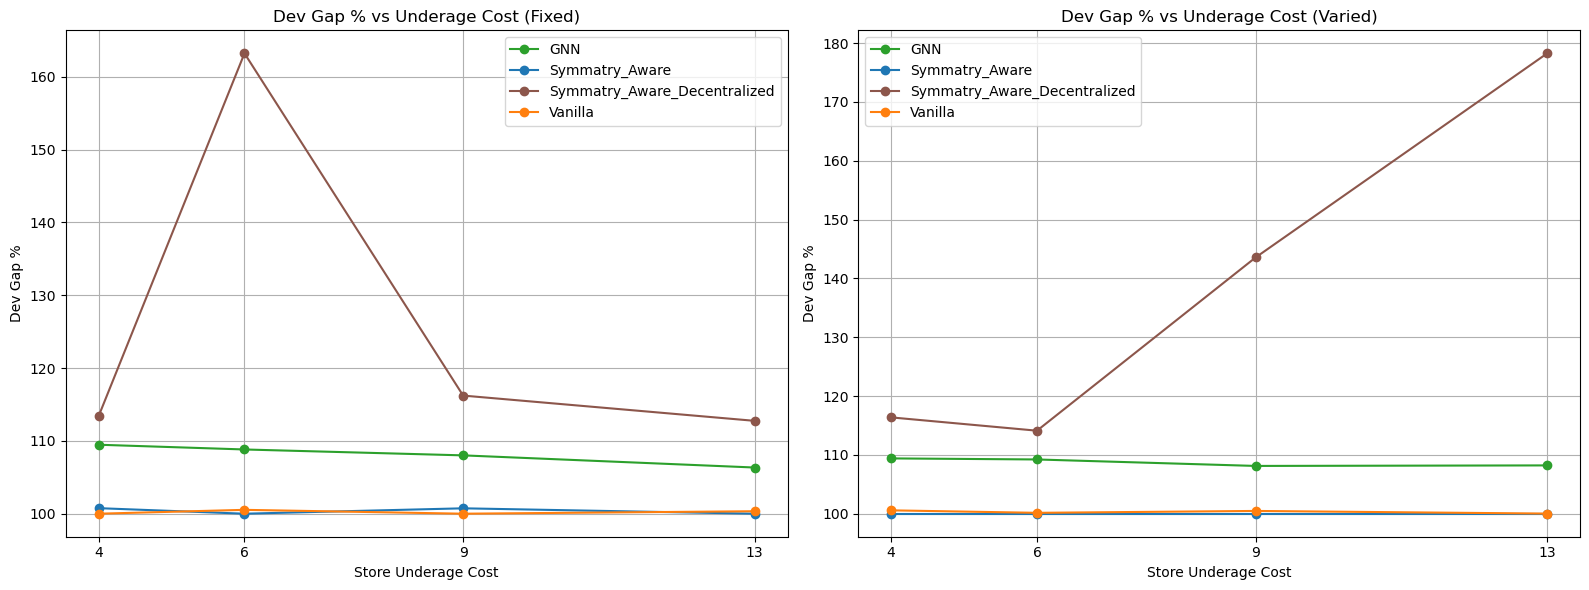

In [123]:
# Define color scheme for architecture types
color_scheme = {
    "Symmatry_Aware": "#1f77b4",  # Blue
    "Vanilla": "#ff7f0e",  # Orange
    "GNN": "#2ca02c",  # Green
    "GNN_PNA": "#d62728",  # Red
    "GNN_MP": "#9467bd",  # Purple
    "Symmatry_Aware_Decentralized": "#8c564b"  # Brown
}

# Create the two side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for df_416_fixed
pivot_df_fixed = df_416_fixed.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_fixed.columns:
    ax1.plot(pivot_df_fixed.index, pivot_df_fixed[column], marker='o', label=column, color=color_scheme[column])
ax1.set_xlabel('Store Underage Cost')
ax1.set_ylabel('Dev Gap %')
ax1.set_title('Dev Gap % vs Underage Cost (Fixed)')
ax1.legend()
ax1.grid(True)
ax1.set_xticks(pivot_df_fixed.index)

# Plot for df_416_varied
pivot_df_varied = df_416_varied.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_varied.columns:
    ax2.plot(pivot_df_varied.index, pivot_df_varied[column], marker='o', label=column, color=color_scheme[column])
ax2.set_xlabel('Store Underage Cost')
ax2.set_ylabel('Dev Gap %')
ax2.set_title('Dev Gap % vs Underage Cost (Varied)')
ax2.legend()
ax2.grid(True)
ax2.set_xticks(pivot_df_varied.index)

plt.tight_layout()
plt.show()

In [126]:
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

symmetry_aware_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores_test/symmetry_aware',
}
vanilla_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores_test/vanilla',
}
gnn_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores_test/GNN',
}

store_underage_cost = [4, 6, 9, 13]
results_interpretor = rri.RayResultsinterpreter()
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn = results_interpretor.make_table(gnn_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_16_fixed = pd.concat([df_symmetry_aware, df_vanilla, df_gnn])

min_dev_loss = df_16_fixed.groupby('store_underage_cost')['Dev Loss'].min()
df_16_fixed['Dev Gap %'] = df_16_fixed.apply(lambda row: ((row['Dev Loss'] - min_dev_loss[row['store_underage_cost']]) / min_dev_loss[row['store_underage_cost']]) * 100, axis=1)
df_16_fixed['Dev Gap %'] = df_16_fixed['Dev Gap %'].round(2) * -1 + 100
columns = df_16_fixed.columns.tolist()
runs_column = columns.pop(columns.index(('# of runs')))
df_16_fixed = df_16_fixed[columns + [runs_column]]
df_16_fixed = df_16_fixed.drop('# of stores', axis=1)
df_16_fixed['n_samples'] = 16

df_16_fixed.sort_values(by=['store_underage_cost'], inplace=True)
print('store primitives fixed over samples. n_samples = 16')
print(df_16_fixed.to_string(index=False))

store primitives fixed over samples. n_samples = 16
Architecture Class  store_underage_cost  Learning Rate  Train Loss    Dev Loss  Dev Gap %  # of runs  n_samples
    Symmatry_Aware                    4          0.001 -174.863958 -142.206457     100.00         18         16
           Vanilla                    4          0.001 -147.306274 -118.692210     116.54         18         16
               GNN                    4          0.010 -154.028720 -138.316794     102.74         18         16
    Symmatry_Aware                    6          0.001 -272.253485 -230.505730     100.00         18         16
           Vanilla                    6          0.001 -263.815851 -201.423857     112.62         18         16
               GNN                    6          0.010 -244.815629 -219.371525     104.83         18         16
    Symmatry_Aware                    9          0.001 -422.981667 -363.707979     100.00         18         16
           Vanilla                    9          0.0

In [125]:
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

symmetry_aware_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_test/symmetry_aware',
}
vanilla_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_test/vanilla',
}
gnn_paths = {
    16: '/user/ml4723/Prj/NIC/ray_results/warehouse_real_test/GNN',
}

store_underage_cost = [4, 6, 9, 13]
results_interpretor = rri.RayResultsinterpreter()
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_gnn = results_interpretor.make_table(gnn_paths, {'store_underage_cost': store_underage_cost}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

df_symmetry_aware.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_16_varied = pd.concat([df_symmetry_aware, df_vanilla, df_gnn])

min_dev_loss = df_16_varied.groupby('store_underage_cost')['Dev Loss'].min()
df_16_varied['Dev Gap %'] = df_16_varied.apply(lambda row: ((row['Dev Loss'] - min_dev_loss[row['store_underage_cost']]) / min_dev_loss[row['store_underage_cost']]) * 100, axis=1)
df_16_varied['Dev Gap %'] = df_16_varied['Dev Gap %'].round(2) * -1 + 100
columns = df_16_varied.columns.tolist()
runs_column = columns.pop(columns.index(('# of runs')))
df_16_varied = df_16_varied[columns + [runs_column]]
df_16_varied = df_16_varied.drop('# of stores', axis=1)
df_16_varied['n_samples'] = 16

df_16_varied.sort_values(by=['store_underage_cost'], inplace=True)
print('store primitives varied over samples. n_samples = 16')
print(df_16_varied.to_string(index=False))

store primitives varied over samples. n_samples = 16
Architecture Class  store_underage_cost  Learning Rate  Train Loss    Dev Loss  Dev Gap %  # of runs  n_samples
    Symmatry_Aware                    4          0.001 -169.312666 -136.169764     100.00         18         16
           Vanilla                    4          0.001 -162.764804 -118.389440     113.06         18         16
               GNN                    4          0.001 -143.456865 -124.979937     108.22         18         16
    Symmatry_Aware                    6          0.001 -260.623668 -216.396671     100.00         18         16
           Vanilla                    6          0.001 -269.501176 -197.261561     108.84         18         16
               GNN                    6          0.001 -241.154719 -207.826588     103.96         18         16
    Symmatry_Aware                    9          0.001 -411.289950 -341.851821     100.00         18         16
           Vanilla                    9          0.

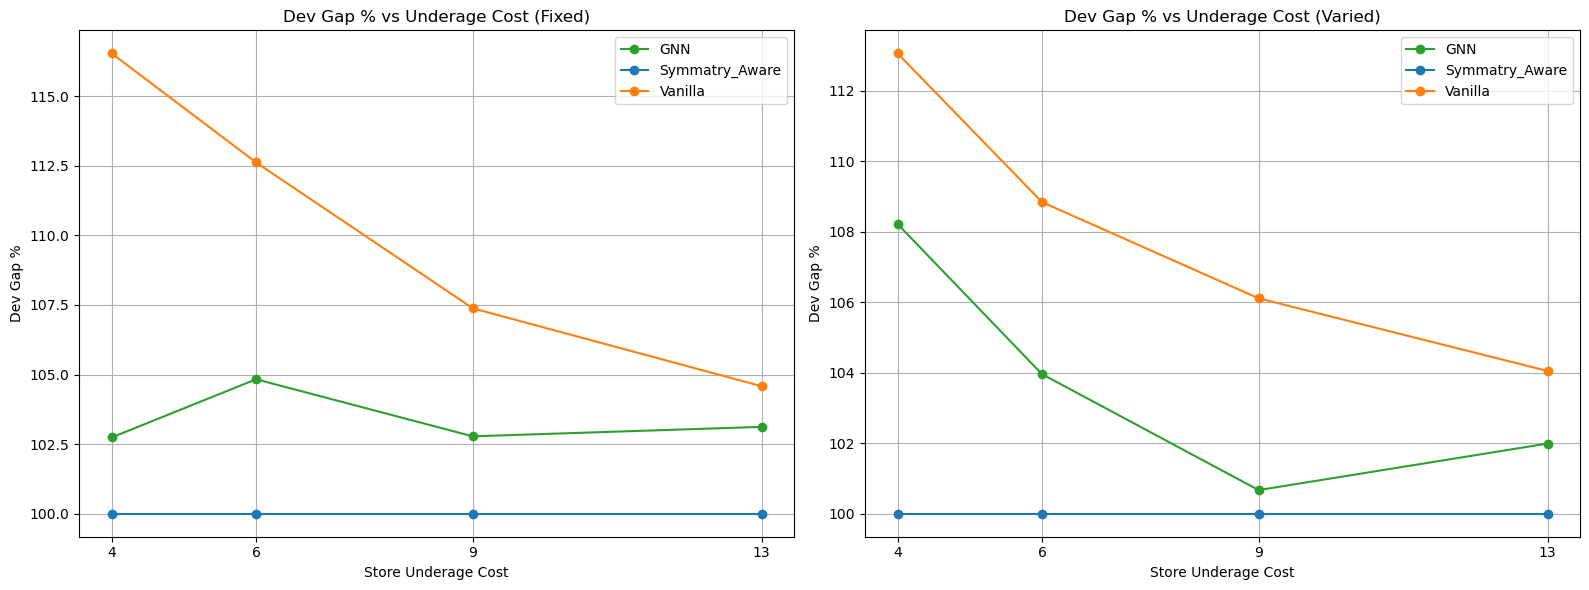

In [124]:
# Create the two side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Plot for df_16_fixed
pivot_df_fixed = df_16_fixed.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_fixed.columns:
    ax1.plot(pivot_df_fixed.index, pivot_df_fixed[column], marker='o', label=column, color=color_scheme[column])
ax1.set_xlabel('Store Underage Cost')
ax1.set_ylabel('Dev Gap %')
ax1.set_title('Dev Gap % vs Underage Cost (Fixed)')
ax1.legend()
ax1.grid(True)
ax1.set_xticks(pivot_df_fixed.index)

# Plot for df_16_varied
pivot_df_varied = df_16_varied.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_varied.columns:
    ax2.plot(pivot_df_varied.index, pivot_df_varied[column], marker='o', label=column, color=color_scheme[column])
ax2.set_xlabel('Store Underage Cost')
ax2.set_ylabel('Dev Gap %')
ax2.set_title('Dev Gap % vs Underage Cost (Varied)')
ax2.legend()
ax2.grid(True)
ax2.set_xticks(pivot_df_varied.index)

plt.tight_layout()
plt.show()


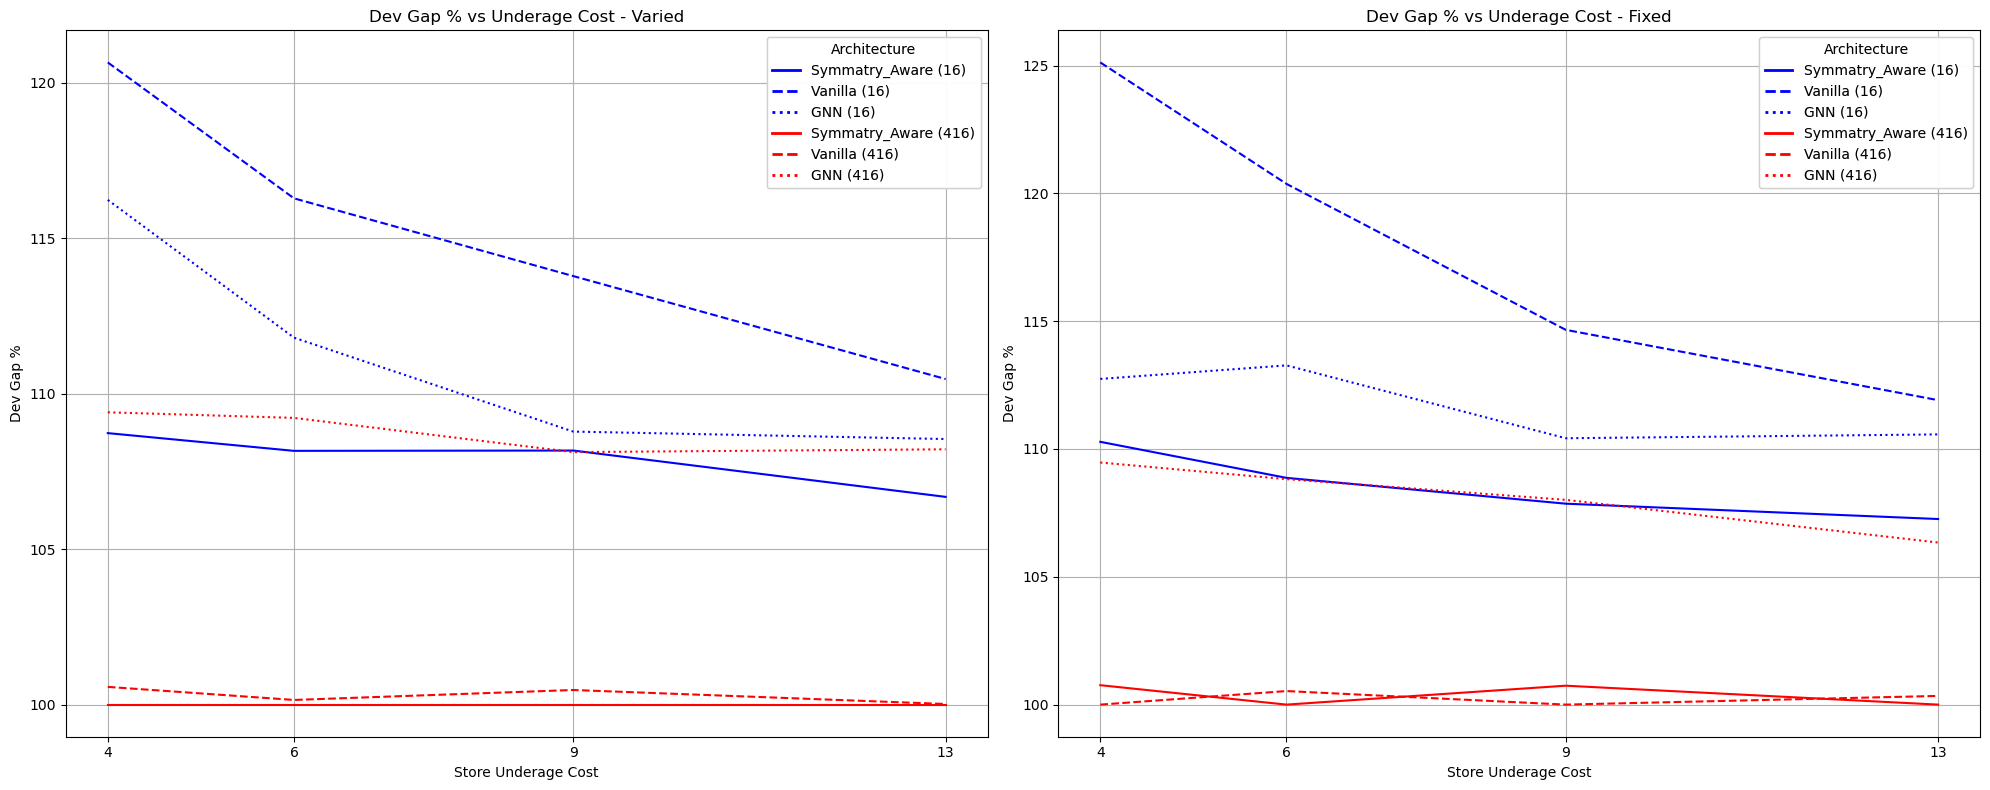

Combined data for 416 and 16 samples (Varied):
          Architecture Class  store_underage_cost  Learning Rate  Train Loss    Dev Loss  # of runs  n_samples  Dev Gap %
              Symmatry_Aware                    4         0.0010 -169.312666 -136.169764         18         16     108.73
                     Vanilla                    4         0.0010 -162.764804 -118.389440         18         16     120.65
                         GNN                    4         0.0010 -143.456865 -124.979937         18         16     116.23
              Symmatry_Aware                    4         0.0010 -166.387470 -149.201746         30        416     100.00
                     Vanilla                    4         0.0001 -164.681627 -148.355062         60        416     100.57
                         GNN                    4         0.0001 -151.413625 -135.183302         30        416     109.40
Symmatry_Aware_Decentralized                    4         0.0010 -146.705925 -124.772651         18

In [134]:
# Combine df_416_varied and df_16_varied
df_combined_varied = pd.concat([df_416_varied, df_16_varied], ignore_index=True)

# Combine df_416_fixed and df_16_fixed
df_combined_fixed = pd.concat([df_416_fixed, df_16_fixed], ignore_index=True)

# Function to process dataframe
def process_dataframe(df):
    # Remove existing 'Dev Gap %' column if it exists
    if 'Dev Gap %' in df.columns:
        df = df.drop('Dev Gap %', axis=1)
    
    # Calculate new Dev Gap %
    min_dev_loss = df.groupby(['store_underage_cost'])['Dev Loss'].transform('min')
    df['Dev Gap %'] = ((df['Dev Loss'] - min_dev_loss) / min_dev_loss) * 100
    df['Dev Gap %'] = df['Dev Gap %'].round(2) * -1 + 100
    
    # Sort the dataframe
    df = df.sort_values(by=['store_underage_cost', 'n_samples'])
    
    return df

# Process both dataframes
df_combined_varied = process_dataframe(df_combined_varied)
df_combined_fixed = process_dataframe(df_combined_fixed)

# Function to create pivot table and plot
def plot_graph(df, ax, title_suffix):
    pivot_df = df.pivot(index=['store_underage_cost', 'n_samples'], 
                        columns=['Architecture Class'], 
                        values='Dev Gap %')

    # Define line styles for each architecture class
    line_styles = {'Symmatry_Aware': '-', 'Vanilla': '--', 'GNN': ':'}
    
    # Define colors for each n_samples
    colors = {16: 'blue', 416: 'red'}
    
    for n_samples in df['n_samples'].unique():
        for arch in df['Architecture Class'].unique():
            if arch == 'Symmatry_Aware_Decentralized':
                continue  # Skip Symmetry_Aware_Decentralized
            data = pivot_df.loc[(slice(None), n_samples), arch]
            ax.plot(data.index.get_level_values(0), 
                    data.values, 
                    linestyle=line_styles[arch], 
                    color=colors[n_samples], 
                    label=f'{arch}, samples={n_samples}')

    ax.set_xlabel('Store Underage Cost')
    ax.set_ylabel('Dev Gap %')
    ax.set_title(f'Dev Gap % vs Underage Cost - {title_suffix}')
    
    # Create custom legend
    from matplotlib.lines import Line2D
    
    # Legend for number of scenarios (samples)
    legend_elements_samples = [Line2D([0], [0], color='blue', lw=2, label='16 scenarios'),
                               Line2D([0], [0], color='red', lw=2, label='416 scenarios')]
    
    # Legend for architecture types
    legend_elements_arch = [Line2D([0], [0], color='black', lw=2, linestyle='-', label='Symmatry_Aware'),
                            Line2D([0], [0], color='black', lw=2, linestyle='--', label='Vanilla'),
                            Line2D([0], [0], color='black', lw=2, linestyle=':', label='GNN')]
    
    # Add both legend boxes
    ax.legend(handles=legend_elements_samples, loc='upper left', title='# of scenarios')
    ax.add_artist(ax.legend(handles=legend_elements_arch, loc='upper right', title='Architecture'))
    
    ax.grid(True)
    ax.set_xticks(pivot_df.index.get_level_values(0).unique())

# Plot graphs for varied and fixed side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

plot_graph(df_combined_varied, ax1, "Varied")
plot_graph(df_combined_fixed, ax2, "Fixed")

plt.tight_layout()
plt.show()

# Print the combined dataframes
print('Combined data for 416 and 16 samples (Varied):')
print(df_combined_varied.to_string(index=False))

print('\nCombined data for 416 and 16 samples (Fixed):')
print(df_combined_fixed.to_string(index=False))


In [2]:
sort_by = 'test_loss'
pick_row_from_run_by = 'dev_loss'
def custom_data_filler(out_row, reference_row):
    pass

ctx_paths = {
    10: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency_random_primitives/ctx/10',
    20: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency_random_primitives/ctx/20',
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency_random_primitives/ctx/50',
}
vanilla_paths = {
    10: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency_random_primitives/vanilla/10',
    20: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency_random_primitives/vanilla/20',
    50: '/user/ml4723/Prj/NIC/ray_results/sample_efficiency_random_primitives/vanilla/50',
}

training_n_samples = [1, 2, 4, 8, 16, 256, 8192]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.rename(columns={'master': 'context size'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

df = pd.concat([df_ctx, df_vanilla])

df.drop(columns=['Learning Rate', 'samples'], inplace=True)

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = (df['Test Loss']/ min_test_loss) * 100

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    'Dev Loss': 'mean',
    'Test Loss': 'mean',
    'Test Gap %': ['mean', 'std'],
    '# of runs': 'sum'
}).reset_index()

# Flatten column names
df_avg.columns = ['_'.join(col).strip() for col in df_avg.columns.values]

# Rename columns for clarity
df_avg.rename(columns={
    '# of stores_': '# of stores',
    'Architecture Class_': 'Architecture Class',
    'training_n_samples_': 'training_n_samples',
    'Train Loss_mean': 'Train Loss',
    'Dev Loss_mean': 'Dev Loss',
    'Test Loss_mean': 'Test Loss',
    'Test Gap %_mean': 'Test Gap %',
    'Test Gap %_std': 'Test Gap % Std',
    '# of runs_sum': '# of runs'
}, inplace=True)

df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', 'Dev Loss', 'Test Loss', 'Test Gap %', 'Test Gap % Std', '# of runs']]
df = df_avg

df.sort_values(by=['# of stores', 'training_n_samples'], inplace=True)
print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %  Test Gap % Std  # of runs
          10     Symmatry_Aware                  16    5.440101  5.564828   5.580484  102.206143             NaN          9
          10            Vanilla                  16    5.412052  6.357321   6.376280  116.781075             NaN         18
          10     Symmatry_Aware                 256    5.405181  5.516602   5.534151  101.357549             NaN          9
          10            Vanilla                 256    5.589822  5.850123   5.854603  107.226597             NaN         18
          10     Symmatry_Aware                8192    5.429354  5.441211   5.460028  100.000000             NaN          9
          10            Vanilla                8192    5.489706  5.516842   5.532883  101.334324             NaN         18
          20     Symmatry_Aware                  16    6.273018  5.870016   5.865684  102.046629             NaN          9
        

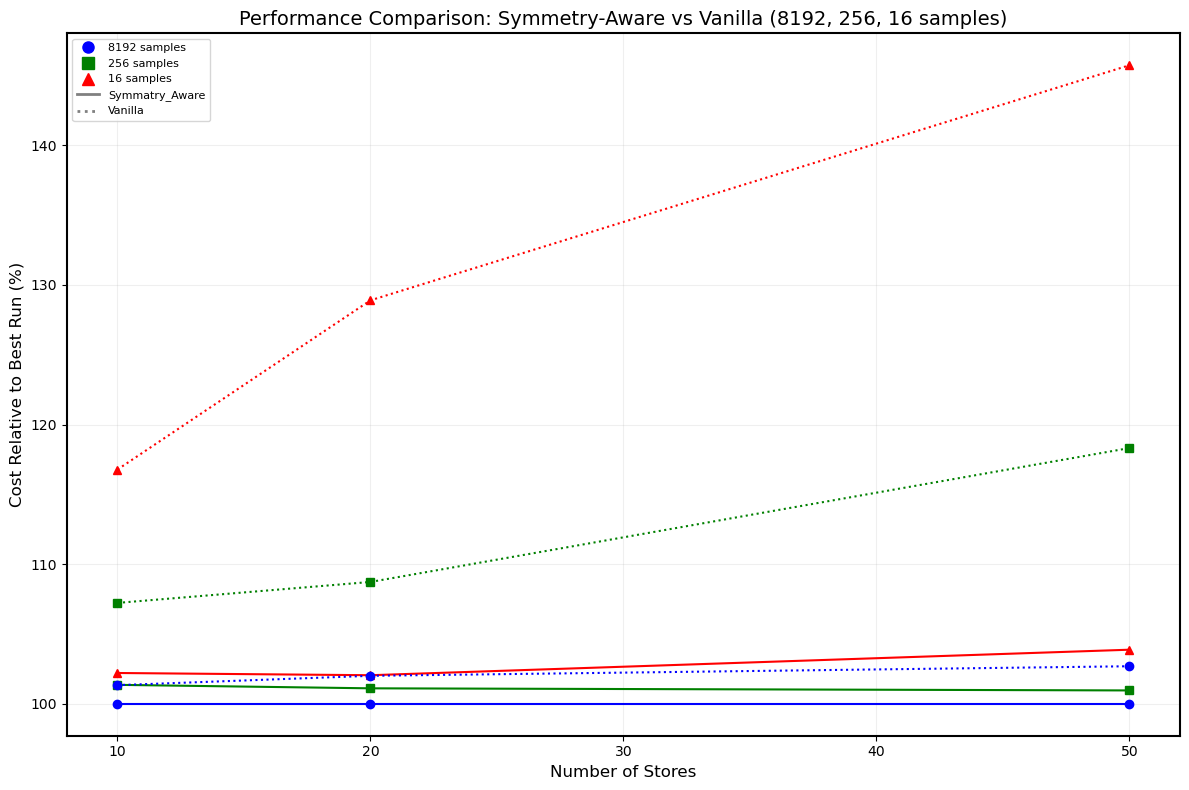

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot style
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for different training_n_samples
colors = {8192: 'blue', 256: 'green', 16: 'red'}

# Define line styles for different architecture classes
line_styles = {'Symmatry_Aware': '-', 'Vanilla': ':'}

# Define markers for different training_n_samples
markers = {8192: 'o', 256: 's', 16: '^'}

# Plot lines for each architecture and training_n_samples combination
for arch in ['Symmatry_Aware', 'Vanilla']:
    for n_samples in [8192, 256, 16]:
        data = df[(df['Architecture Class'] == arch) & (df['training_n_samples'] == n_samples)]
        ax.plot(data['# of stores'], data['Test Gap %'], 
                 color=colors[n_samples],
                 linestyle=line_styles[arch],
                 marker=markers[n_samples],
                 label=f'{arch}, {n_samples} samples')

# Customize the plot
ax.set_xlabel('Number of Stores', fontsize=12)
ax.set_ylabel('Cost Relative to Best Run (%)', fontsize=12)
ax.set_title('Performance Comparison: Symmetry-Aware vs Vanilla (8192, 256, 16 samples)', fontsize=14)
ax.set_xticks([10, 20, 30, 40, 50])
ax.set_xticklabels(['10', '20', '30', '40', '50'])
ax.grid(True, which="both", ls="-", alpha=0.2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Create custom legend
legend_elements = []

# Add marker legend for samples
for n_samples, marker in markers.items():
    legend_elements.append(plt.Line2D([0], [0], marker=marker, color=colors[n_samples], linestyle='None', markersize=8, label=f'{n_samples} samples'))

# Add line style legend for architecture types
for arch, style in line_styles.items():
    legend_elements.append(plt.Line2D([0], [0], color='gray', linestyle=style, lw=2, label=arch))

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()